# Deep Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Objectdetectie](#Model1)
    - [Ondertiteling van afbeeldinge](#Model2)
    - [Beeldgeneratie](#Model3)
    - [Implementatie](#Model4)
- [Results](#results)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [14]:
# !pip install keras-tuner --upgrade
# !pip install wordcloud
# !pip install tqdm
# !pip install ultralytics

In [15]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import random
import torch
import glob
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Overview

In [16]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [17]:
img_train = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Train"
img_test = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test"


In [18]:
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 3 Datasets/submission_example.csv')

## Exploratory Data Analysis

#### Train data

In [44]:
# ImageDataGenerator aanmaken
datagen = ImageDataGenerator(rescale=1./255)  # normaliseer de beelden

# Laad de data automatisch uit submappen
train_data = datagen.flow_from_directory(
    img_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", train_data.class_indices)

Found 2145 images belonging to 2 classes.
Klassen en hun indexen: {'images': 0, 'labels': 1}


#### Test data

In [45]:
test_data = datagen.flow_from_directory(
    img_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", test_data.class_indices)


Found 537 images belonging to 1 classes.
Klassen en hun indexen: {'images': 0}


## Voorbeeld afbeeldingen

### Train afbeeldingen

In [46]:
def toon_afbeeldingen_uit_batch(data, num_images):
    """
    Toont een aantal afbeeldingen uit een batch van een ImageDataGenerator.

    Parameters:
    - data: de ImageDataGenerator (flow_from_directory)
    - num_images: het aantal afbeeldingen om te tonen
    """
    # Haal een batch op
    images, labels = next(data)

    # Plot de afbeeldingen
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


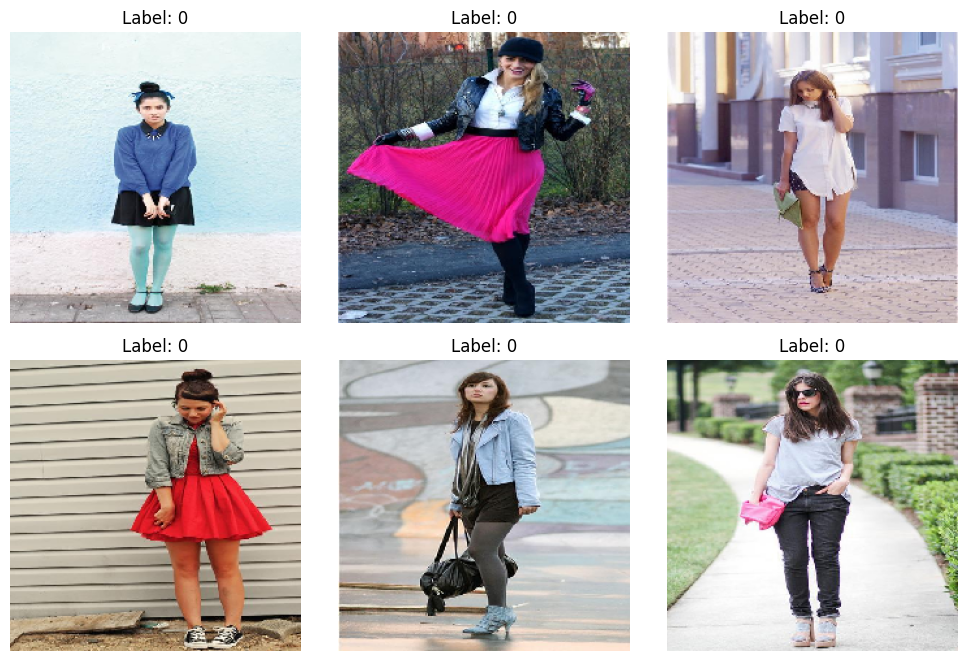

In [ ]:
train_data_show = toon_afbeeldingen_uit_batch(train_data, 6)

### Test afbeeldingen

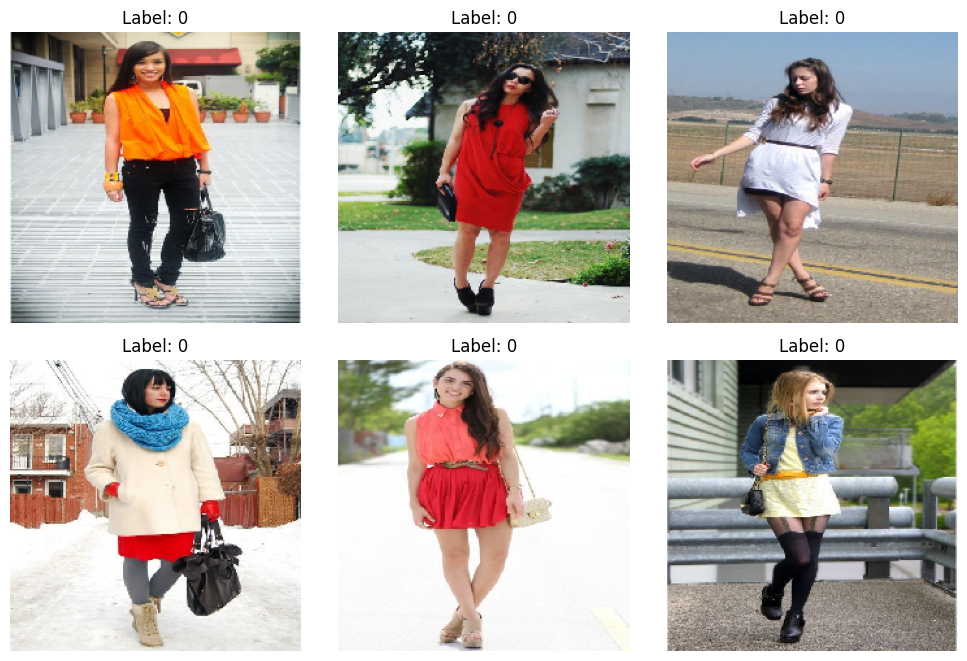

In [ ]:
test_data_show = toon_afbeeldingen_uit_batch(test_data,6)

## Breedte & Hoogte verdeling

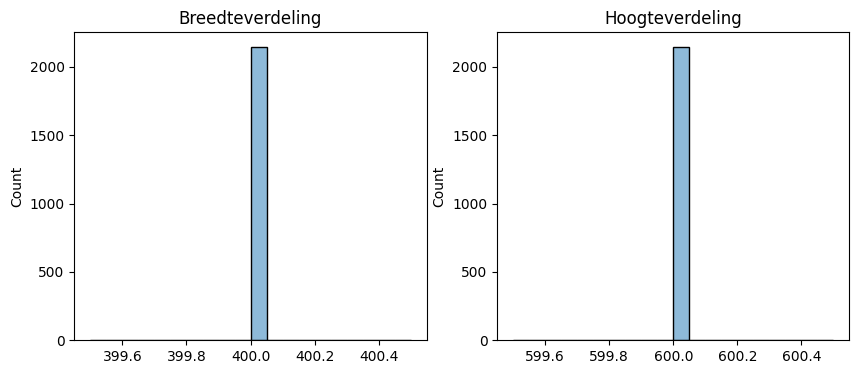

In [ ]:
def verzamel_afmetingen(data):
    sizes = []
    for label in os.listdir(data):
        label_path = os.path.join(data, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(label_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes.append(img.size)
                    except:
                        continue
    return sizes

afmetingen = verzamel_afmetingen(img_train)

# Visualiseer

widths = [s[0] for s in afmetingen]
heights = [s[1] for s in afmetingen]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Breedteverdeling")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Hoogteverdeling")
plt.show()



De histogrammen laten zien dat bijna alle objecten precies dezelfde breedte en hoogte hebben. De breedte is altijd 400 eenheden en de hoogte is altijd 600 eenheden. Er is vrijwel geen verschil tussen de objecten, want de pieken in de histogrammen zijn heel scherp en geconcentreerd op die waarden.

Dit betekent dat de dataset erg uniform is. Mogelijk zijn de objecten bewust zo gemaakt of geselecteerd met vaste afmetingen, bijvoorbeeld omdat de afbeeldingen allemaal hetzelfde formaat hebben. Het ontbreken van variatie in breedte en hoogte is opvallend en kan invloed hebben op hoe een model leert, omdat het weinig verschillende vormen ziet.

## Controle op corrupte afbeeldingen

In [ ]:
def controleer_corruptie(data):
    fouten = []
    for root, dirs, files in os.walk(data):
        for name in files:
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, name)
                with Image.open(path) as img:
                        img.verify()

    return fouten

corrupt = controleer_corruptie(img_train)
print(f"Corrupt of onleesbare afbeeldingen gevonden: {len(corrupt)}")


Corrupt of onleesbare afbeeldingen gevonden: 0


De code controleert of er beschadigde of onleesbare afbeeldingen in de dataset zitten. Het resultaat geeft aan dat er geen corrupte afbeeldingen zijn gevonden. Dit betekent dat alle beelden goed leesbaar en bruikbaar zijn voor verdere verwerking.

## Voorbeeldbeelden met kleurverdeling

In [47]:
images_dir = img_train + '/images'

In [ ]:
def toon_images_met_histogram(map_pad, aantal):
    # Pak alle afbeelding-bestanden in de map
    image_files = [f for f in os.listdir(map_pad) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # if len(image_files) < aantal:
    #     print(f"Niet genoeg afbeeldingen in de map ({len(image_files)} gevonden, {aantal} gevraagd).")
    #     return

    # Kies random aantal afbeeldingen
    gekozen = random.sample(image_files, aantal)

    plt.figure(figsize=(12, 4 * aantal))

    for i, fname in enumerate(gekozen):
        path = os.path.join(map_pad, fname)
        img = cv2.imread(path)
        # if img is None:
        #     print(f"Kan {fname} niet laden!")
        #     continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = cv2.split(img)

        # Toon afbeelding
        plt.subplot(aantal, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')

        # Toon histogram
        plt.subplot(aantal, 2, i*2 + 2)
        plt.hist(r.ravel(), bins=256, color='r', alpha=0.5, label='Rood')
        plt.hist(g.ravel(), bins=256, color='g', alpha=0.5, label='Groen')
        plt.hist(b.ravel(), bins=256, color='b', alpha=0.5, label='Blauw')
        plt.title("RGB Histogram")
        plt.xlabel("Pixelwaarde")
        plt.ylabel("Aantal pixels")
        plt.legend()

    plt.tight_layout()
    plt.show()


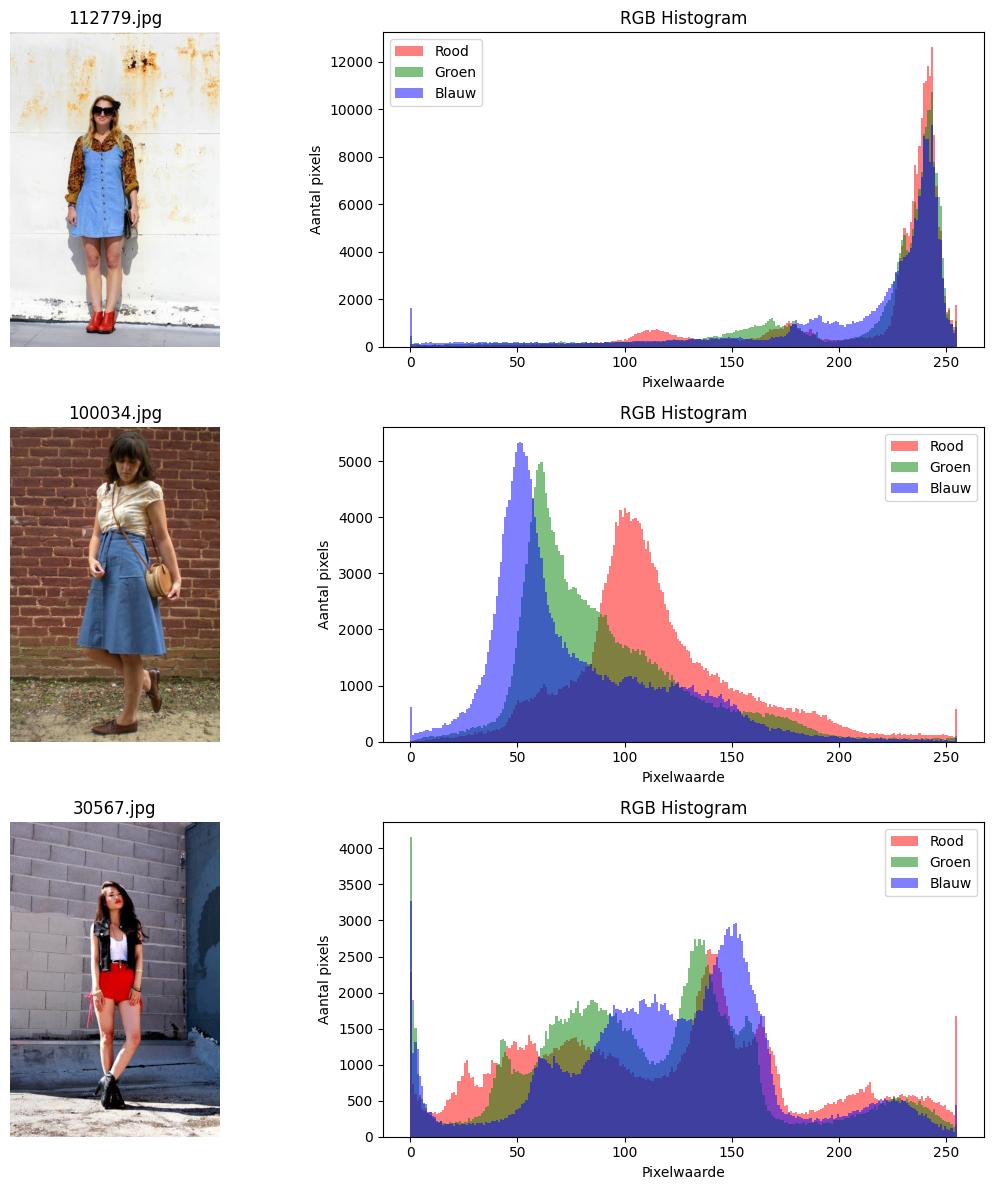

In [ ]:
toon_images_met_histogram(images_dir, 3)


De kleuren verschillen sterk per afbeelding. Dit zie je ook terug in de RGB-histogrammen. Elke afbeelding heeft een andere verdeling van rood, groen en blauw.

Sommige foto's hebben veel heldere kleuren zoals geel en groen, terwijl andere juist warme tinten bevatten zoals rood en bruin. Ook de hoeveelheid licht en schaduw speelt een rol.

De histogrammen laten zien welke kleuren het meest aanwezig zijn in de afbeelding. Hoge pieken in één kleur betekenen dat die kleur veel voorkomt. Als de pieken van rood en groen overlappen, zie je bijvoorbeeld veel geel.

De kleurverdeling is niet altijd gelijk. Elke afbeelding heeft zijn eigen sfeer en dominante kleuren, en dat zie je goed terug in de histogrammen. Dit kan invloed hebben op het model, omdat het model kleuren gebruikt als visuele informatie om objecten te herkennen. Grote kleurverschillen kunnen ervoor zorgen dat het model sommige objecten beter of juist slechter leert herkennen.

### Afbeeldingen met labels

In [48]:
def toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, aantal):
    # Kies willekeurige afbeeldingen
    alle_afbeeldingen = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    gekozen_afbeeldingen = random.sample(alle_afbeeldingen, min(aantal, len(alle_afbeeldingen)))

    plt.figure(figsize=(6 * aantal, 6))

    for idx, gekozen_afb in enumerate(gekozen_afbeeldingen):
        naam_zonder_ext = os.path.splitext(gekozen_afb)[0]
        label_pad = os.path.join(labels_dir, f"{naam_zonder_ext}.txt")
        image_pad = os.path.join(images_dir, gekozen_afb)

        # Laad de afbeelding
        img = cv2.imread(image_pad)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Lees labelbestand en teken bounding boxes
        if os.path.exists(label_pad):
            with open(label_pad, 'r') as f:
                for line in f:
                    delen = line.strip().split()
                    class_id = int(delen[0])
                    cx, cy, bw, bh = map(float, delen[1:])

                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, class_dict[class_id], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Plot afbeelding
        plt.subplot(1, aantal, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(gekozen_afb)

    plt.tight_layout()
    plt.show()

# Klassen
class_dict = {
    0: "sunglass", 1: "hat", 2: "jacket", 3: "shirt", 4: "pants",
    5: "shorts", 6: "skirt", 7: "dress", 8: "bag", 9: "shoe"
}




In [49]:
labels_dir = img_train + '/labels'


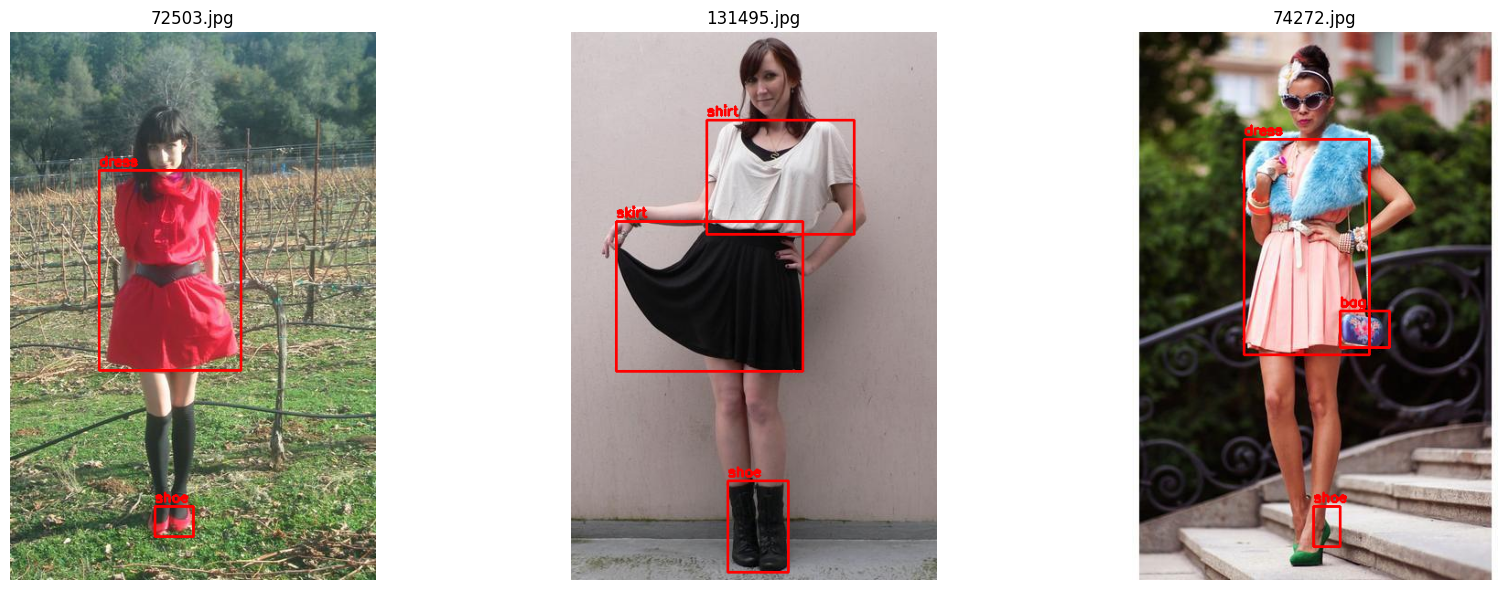

In [ ]:
toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, 3)

De labels zijn over het algemeen goed gedaan voor de kledingstukken en accessoires. De meeste objecten zijn duidelijk en correct gelabeld. Maar bij de schoenen is dat wat minder goed gegaan. Sommige schoenen zijn niet goed zichtbaar op de afbeelding of zijn niet helemaal juist gelabeld.

Dat kan een probleem zijn voor het model. Als de schoenen niet goed gelabeld zijn, wordt het voor het model moeilijker om te leren wat een schoen precies is. Hierdoor kan het model minder goed schoenen herkennen tijdens het testen. Dit kan de nauwkeurigheid van het model negatief beïnvloeden, vooral voor de klasse "schoen", ook al is dat de meest voorkomende klasse in de dataset.

Het is dus belangrijk om ook bij veelvoorkomende klassen te zorgen voor goede en duidelijke labels, zodat het model betrouwbare resultaten kan geven.

### De klassenverdeling in de labels

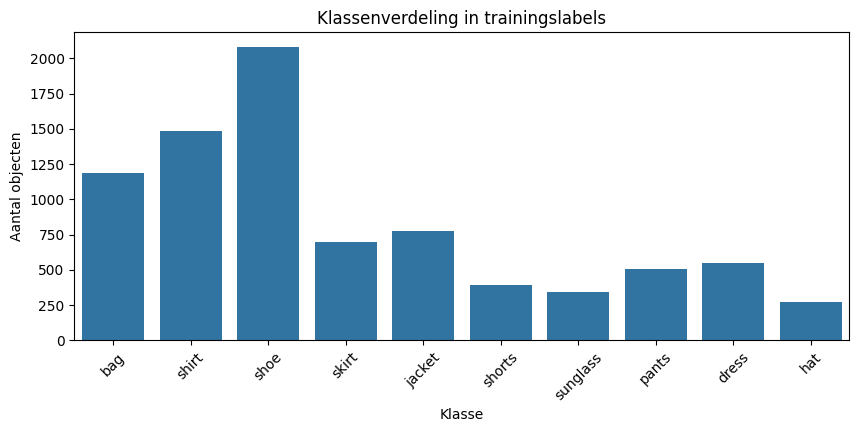

In [ ]:
def analyseer_klassenverdeling(label_dir):
    counter = Counter()
    for lbl in os.listdir(label_dir):
        if lbl.endswith(".txt"):
            with open(os.path.join(label_dir, lbl), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    counter[class_id] += 1
    return counter


verdeling = analyseer_klassenverdeling(labels_dir)

# Visualiseren
plt.figure(figsize=(10, 4))
sns.barplot(x=[class_dict[k] for k in verdeling.keys()], y=list(verdeling.values()))
plt.title("Klassenverdeling in trainingslabels")
plt.ylabel("Aantal objecten")
plt.xlabel("Klasse")
plt.xticks(rotation=45)
plt.show()


De staafdiagram laat zien hoe de objectklassen verdeeld zijn in de trainingslabels. Op de x-as staan de klassen en op de y-as het aantal objecten per klasse.

Schoenen komen het meest voor, met meer dan 2000 objecten. Daarna komen shirts met ongeveer 1500 objecten, gevolgd door tassen met 1200. Jassen en rokken hebben elk tussen de 700 en 800 objecten. Broeken en jurken hebben ongeveer 500 objecten. Korte broeken en zonnebrillen zijn minder vaak aanwezig, met ongeveer 350 en 300 objecten. Hoeden komen het minst voor, iets meer dan 250 keer.

De staafdiagram laat duidelijk zien dat de verdeling van klassen ongelijk is. Dit noemen we een ongebalanceerde dataset. Dat kan invloed hebben op het trainen van een model. Het model leert dan beter de veelvoorkomende klassen te herkennen en minder goed de zeldzame.

## Feature Engineering

## Modeling

### Objectdetectie

In [51]:
import os
import shutil
import random

random.seed(42)

# Originele train folders
images_dir = f"{img_train}/images"
labels_dir = f"{img_train}/labels"

dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/'
# Nieuwe mappen voor split
train_images_dir = f'{dir}train/images'
train_labels_dir = f'{dir}train/labels'
val_images_dir = f'{dir}val/images'
val_labels_dir = f'{dir}val/labels'

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Alle afbeeldingen in train
all_images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Shuffle en split 80% train, 20% val
random.shuffle(all_images)
split_idx = int(len(all_images)*0.8)
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

# Functie om bestanden te kopiëren
def copy_files(file_list, src_images, src_labels, dst_images, dst_labels):
    for file_name in file_list:
        # kopieer afbeelding
        shutil.copy(os.path.join(src_images, file_name), os.path.join(dst_images, file_name))
        # kopieer label (zelfde naam maar .txt extensie)
        label_name = os.path.splitext(file_name)[0] + '.txt'
        shutil.copy(os.path.join(src_labels, label_name), os.path.join(dst_labels, label_name))

# Kopieer train bestanden
copy_files(train_images, images_dir, labels_dir, train_images_dir, train_labels_dir)
# Kopieer val bestanden
copy_files(val_images, images_dir, labels_dir, val_images_dir, val_labels_dir)


In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17483, done.
remote: Total 17483 (delta 0), reused 0 (delta 0), pack-reused 17483 (from 1)
Receiving objects: 100% (17483/17483), 16.58 MiB | 27.13 MiB/s, done.
Resolving deltas: 100% (11991/11991), done.


In [ ]:
# Installeer dependencies van YOLOv5 (alleen nodig bij eerste keer)
%cd yolov5
!pip install -r requirements.txt
%cd ..


/content/yolov5
/content


In [ ]:
# Pad naar het data.yaml bestand in de Colab-omgeving
yaml_file_path = '/content/data.yaml'

# Inhoud van het data.yaml bestand
yaml_content = """
train: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/train/images
val: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images


nc: 10
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']

"""

# Schrijf de inhoud naar het bestand
with open(yaml_file_path, 'w') as f:
    f.write(yaml_content)

print(f"'{yaml_file_path}' is aangepast.")

'/content/data.yaml' is aangepast.


In [ ]:
!python /content/yolov5/train.py --data /content/data.yaml --weights yolov5m.pt --img 640 --epochs 50 --batch-size 32

Streaminguitvoer ingekort tot de laatste 5000 regels.
       5/49      12.7G    0.04422    0.03955    0.01525        244        640:  96% 52/54 [00:52<00:02,  1.10s/it]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       5/49      12.7G    0.04419    0.03958    0.01524        242        640:  98% 53/54 [00:54<00:01,  1.38s/it]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       5/49      12.7G    0.04428    0.03944    0.01529        112        640: 100% 54/54 [00:54<00:00,  1.02s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 7/7 [00:07<00:00,  1.03s/it]
                   all        429       1680      0.647      0.732       0.71      0.356

      Epo

In [ ]:
!python /content/yolov5/detect.py \
  --weights /content/yolov5/runs/train/exp/weights/best.pt \
  --source "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images" \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --project /content/yolov5/runs/detect \
  --name test_predictions \
  --exist-ok


detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolov5/runs/detect, name=test_predictions, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-419-gcd44191c Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20889303 parameters, 0 gradients, 48.0 GFLOPs
image 1/537 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images/10084.jpg: 640x448 1 jacket, 2 shirts, 1 skirt, 1 bag, 1 shoe, 46.6ms
image 2/537 /content/drive/MyDrive/Colab Notebooks/Portfo

In [ ]:
import os
import glob
import torch
import pandas as pd
from PIL import Image


# Zoek automatisch het pad naar best.pt (laatste experiment)
runs_dir = '/content/yolov5/runs/train'
list_of_runs = glob.glob(f'{runs_dir}/exp*')
if not list_of_runs:
    raise FileNotFoundError(f"Geen experimenten gevonden in {runs_dir}")

latest_run_dir = max(list_of_runs, key=os.path.getctime)
weights_path = os.path.join(latest_run_dir, 'weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Bestand niet gevonden: {weights_path}")

# Laad het getrainde YOLOv5-model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)
model.eval()  # Belangrijk voor evaluatie (geen dropout, batchnorm in eval mode)

# Pad naar testafbeeldingen en output-CSV
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images'
submission_output_path = '/content/submission.csv'

# Functie om voorspellingen te maken en te formatteren
def predict_model(image_path):
    results = model(image_path)
    img = Image.open(image_path)
    w_img, h_img = img.size

    preds = []
    if results.pred is not None and len(results.pred) > 0:
        for *box, conf, cls in results.pred[0].tolist():
            xmin, ymin, xmax, ymax = box
            cx = (xmin + xmax) / 2 / w_img
            cy = (ymin + ymax) / 2 / h_img
            bw = (xmax - xmin) / w_img
            bh = (ymax - ymin) / h_img
            preds.extend([
                int(cls),
                round(conf, 4),
                round(cx, 6),
                round(cy, 6),
                round(bw, 6),
                round(bh, 6)
            ])
    return preds

# Verwerk alle testafbeeldingen en maak predictions
all_test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
all_test_images.sort()

submission_data = {
    'id': [],
    'predictions': []
}

for img_name in all_test_images:
    img_path = os.path.join(test_images_dir, img_name)
    preds_list = predict_model(img_path)

    # Formatteer als comma-separated string in lijstnotatie: [0,0.99,0.5,...]
    preds_string = ",".join([str(p) for p in preds_list])
    preds_string = f'[{preds_string}]'

    # Verwijder de extensie (.jpg) voor de id-kolom
    image_id = os.path.splitext(img_name)[0]

    submission_data['id'].append(image_id)
    submission_data['predictions'].append(preds_string)

# Maak en exporteer de CSV
df_submission = pd.DataFrame(submission_data)
df_submission.to_csv(submission_output_path, index=False)

print(f'Submission bestand opgeslagen in: {submission_output_path}')


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-5-31 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20889303 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/

Submission bestand opgeslagen in: /content/submission.csv


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

In [ ]:
# Pad naar jouw training run
results_csv_path1 = '/content/yolov5/runs/train/exp/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path1)

df.tail()

epoch     train/box_loss     train/obj_loss  \
45                 45           0.022053           0.025312   
46                 46           0.021721           0.025290   
47                 47           0.021394           0.025133   
48                 48           0.021204           0.024246   
49                 49           0.020929           0.024825   

       train/cls_loss  metrics/precision  ...       val/obj_loss  \
45           0.004646            0.79722  ...           0.036810   
46           0.004534            0.80641  ...           0.037603   
47           0.004483            0.78753  ...           0.037320   
48           0.004605            0.79421  ...           0.037391   
49           0.004349            0.80502  ...           0.037277   

         val/cls_loss              x/lr0              x/lr1              x/lr2  
45           0.008673           0.001288           0.001288           0.001288  
46           0.008762           0.001090           0.001090           0.001090  
47           0.008938           0.000892           0.000892           0.000892  
48           0.009019           0.000694           0.000694           0.000694  
49           0.008830           0.000496           0.000496           0.000496  

[5 rows x 14 columns]

25 epochs

In [ ]:
# Pad naar jouw training run
results_csv_path = '/content/yolov5/runs/train/exp2/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path)

df

epoch     train/box_loss     train/obj_loss  \
0                   0           0.083021           0.063074   
1                   1           0.062982           0.048551   
2                   2           0.060614           0.043917   
3                   3           0.053233           0.041145   
4                   4           0.047312           0.041063   
5                   5           0.044323           0.039697   
6                   6           0.041640           0.039658   
7                   7           0.040094           0.038000   
8                   8           0.038963           0.038233   
9                   9           0.037802           0.037513   
10                 10           0.036339           0.037181   
11                 11           0.036021           0.036083   
12                 12           0.035268           0.036777   
13                 13           0.033867           0.035971   
14                 14           0.033242           0.035409   
15                 15           0.032951           0.034902   
16                 16           0.031576           0.034442   
17                 17           0.030982           0.033313   
18                 18           0.030368           0.032720   
19                 19           0.029494           0.032578   
20                 20           0.028577           0.031599   
21                 21           0.028198           0.030996   
22                 22           0.027858           0.030998   
23                 23           0.027280           0.030589   
24                 24           0.026108           0.029812   

       train/cls_loss  metrics/precision  ...       val/obj_loss  \
0            0.052098            0.42729  ...           0.051379   
1            0.032132            0.47028  ...           0.034036   
2            0.025677            0.39751  ...           0.032999   
3            0.020788            0.46190  ...           0.031942   
4            0.017501            0.62073  ...           0.032653   
5            0.015065            0.63302  ...           0.034212   
6            0.013754            0.72570  ...           0.032997   
7            0.012406            0.72650  ...           0.032033   
8            0.012223            0.73050  ...           0.032354   
9            0.011545            0.72574  ...           0.032543   
10           0.010631            0.72216  ...           0.032612   
11           0.010633            0.75170  ...           0.032688   
12           0.010065            0.73521  ...           0.032786   
13           0.009579            0.76674  ...           0.032541   
14           0.009350            0.75021  ...           0.032054   
15           0.008923            0.75114  ...           0.031879   
16           0.008367            0.76203  ...           0.032593   
17           0.008206            0.74715  ...           0.032776   
18           0.007690            0.75059  ...           0.033081   
19           0.007427            0.76101  ...           0.033287   
20           0.007300            0.75660  ...           0.032377   
21           0.007267            0.76099  ...           0.032773   
22           0.006644            0.75753  ...           0.033500   
23           0.006636            0.77103  ...           0.032943   
24           0.006272            0.76332  ...           0.033328   

         val/cls_loss              x/lr0              x/lr1              x/lr2  
0            0.033125           0.070556           0.003272           0.003272  
1            0.022291           0.040294           0.006343           0.006343  
2            0.017266           0.009768           0.009151           0.009151  
3            0.013786           0.008812           0.008812           0.008812  
4            0.012121           0.008812           0.008812           0.008812  
5            0.011512           0.008416           0.008416           0.008416  
6            0.009950           0.008020 

### Ondertiteling van afbeeldinge

### Beeldgeneratie

### Implementatie

### Scoren:

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

#### Bevindingen modellen

## Conclusion & Advice

## Sources

### Submission functie

In [ ]:
def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df


In [ ]:
# create_submission(y_pred, df_test, 'test.csv', le)

filename    genre
0    test.00000.wav     rock
1    test.00001.wav  country
2    test.00002.wav      pop
3    test.00003.wav    blues
4    test.00004.wav  country
..              ...      ...
124  test.00124.wav   reggae
125  test.00125.wav  country
126  test.00126.wav   hiphop
127  test.00127.wav  country
128  test.00128.wav      pop

[129 rows x 2 columns]

### Html

In [ ]:
# Upload ipynb
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test model

In [52]:
data_dir  = dir

In [6]:
# import os
# import shutil
# from pathlib import Path

# # 💡 Remove the entire dataset folder if it exists
# if os.path.exists(data_dir):
#     shutil.rmtree(data_dir)

# # Define all needed subdirectories
# # subdirs = [
#     Path(data_dir) / 'model/images/train',
#     Path(data_dir) / 'model/images/val',
#     Path(data_dir) / 'model/labels/train',
#     Path(data_dir) / 'model/labels/val',
#

In [24]:
# from pathlib import Path

# images_path = Path(img_train) / "images"
# labels_path = Path(img_train) / "labels"

In [26]:
# images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
# labels = [f.replace('.jpg', '.txt') for f in images]


In [28]:
# # Create all directories
# for subdir in subdirs:
#     subdir.mkdir(parents=True, exist_ok=True)

# from sklearn.model_selection import train_test_split
# train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# # copy data
# for img, lbl in zip(train_images, train_labels):
#     shutil.copy(Path(images_path) / img, Path(data_dir) / 'model/images/train' / img)
#     shutil.copy(Path(labels_path) / lbl, Path(data_dir) / 'model/labels/train' / lbl)

# for img, lbl in zip(test_images, test_labels):
#     shutil.copy(Path(images_path) / img, Path(data_dir) / 'model/images/val' / img)
#     shutil.copy(Path(labels_path) / lbl, Path(data_dir) / 'model/labels/val' / lbl)

In [53]:
import yaml
from pathlib import Path

# 🧾 YAML bestand aanmaken voor YOLO training
data_yaml = {
    'train': '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/train/images', # Use absolute path
    'val': '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images', # Use absolute path
    'nc': 10,
    'names': ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
}
with open('/content/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [54]:
from pathlib import Path
# 📂 Output folder voor trainingsresultaten
project_path = Path(data_dir) / 'runs'
project_path.mkdir(parents=True, exist_ok=True)

In [ ]:
from ultralytics import YOLO
from pathlib import Path

# Laad het model (bijv. klein YOLOv8n)
model = YOLO('yolov8n.pt')

# Start training
model.train(
    data='/content/data.yaml',
    epochs=50,
    imgsz=640,
    project='/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs',
    name='clothing_model',
    exist_ok=True
)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=clothing_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

train: Scanning /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/train/labels.cache... 1716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1716/1716 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.6±0.6 ms, read: 9.7±8.7 MB/s, size: 37.2 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/labels.cache... 429 images, 0 backgrounds, 0 corrupt: 100%|██████████| 429/429 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.22G      1.415      2.931      1.432         40        640: 100%|██████████| 108/108 [00:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


                   all        429       1665      0.635      0.504      0.533      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.33G      1.333       1.71      1.331         30        640: 100%|██████████| 108/108 [00:36<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


                   all        429       1665      0.593      0.605      0.631      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.35G      1.302      1.576      1.318         42        640: 100%|██████████| 108/108 [00:36<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


                   all        429       1665      0.617      0.641      0.656      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.36G       1.28      1.456      1.305         26        640: 100%|██████████| 108/108 [00:36<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]

                   all        429       1665      0.646      0.624       0.67      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.38G       1.27      1.405      1.292         39        640: 100%|██████████| 108/108 [00:36<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]


                   all        429       1665      0.675      0.672      0.692      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.39G       1.25      1.331      1.277         21        640: 100%|██████████| 108/108 [00:37<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


                   all        429       1665      0.671      0.711      0.702       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.39G      1.235       1.27      1.262         33        640: 100%|██████████| 108/108 [00:36<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.30it/s]

                   all        429       1665      0.621      0.698      0.697      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.4G      1.218      1.235      1.254         27        640: 100%|██████████| 108/108 [00:36<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]


                   all        429       1665      0.717      0.692      0.726       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.4G      1.218      1.204      1.265         27        640: 100%|██████████| 108/108 [00:36<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


                   all        429       1665      0.674      0.724      0.725      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.4G      1.191      1.158      1.241         44        640: 100%|██████████| 108/108 [00:37<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

                   all        429       1665      0.674      0.697      0.716      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.4G      1.172      1.112      1.231         28        640: 100%|██████████| 108/108 [00:37<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

                   all        429       1665      0.716      0.713      0.735      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.4G      1.176        1.1      1.229         39        640: 100%|██████████| 108/108 [00:38<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]

                   all        429       1665      0.665      0.727      0.731      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.4G      1.149      1.062      1.214         31        640: 100%|██████████| 108/108 [00:39<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]

                   all        429       1665      0.659      0.752      0.743      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.4G      1.146      1.058      1.212         26        640: 100%|██████████| 108/108 [00:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.42it/s]


                   all        429       1665      0.754      0.715      0.752      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.4G      1.154      1.037      1.216         30        640: 100%|██████████| 108/108 [00:38<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


                   all        429       1665      0.796        0.7      0.756        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.4G      1.139      1.011      1.216         29        640: 100%|██████████| 108/108 [00:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.29it/s]


                   all        429       1665      0.745       0.74      0.764      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.4G      1.137      1.004      1.205         39        640: 100%|██████████| 108/108 [00:38<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


                   all        429       1665      0.696      0.737      0.752      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.4G      1.109     0.9687      1.199         30        640: 100%|██████████| 108/108 [00:37<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]


                   all        429       1665      0.701      0.752       0.75      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.4G      1.107     0.9698      1.191         40        640: 100%|██████████| 108/108 [00:37<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]

                   all        429       1665      0.689      0.773      0.771      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.4G      1.112     0.9577      1.194         27        640: 100%|██████████| 108/108 [00:38<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


                   all        429       1665      0.738      0.735      0.746      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.4G      1.106     0.9469      1.193         20        640: 100%|██████████| 108/108 [00:38<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


                   all        429       1665      0.761      0.733      0.759      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.4G      1.096     0.9175      1.183         34        640: 100%|██████████| 108/108 [00:37<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.20it/s]

                   all        429       1665        0.7      0.756      0.759      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.4G      1.077     0.9091      1.174         18        640: 100%|██████████| 108/108 [00:38<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]

                   all        429       1665       0.72      0.747      0.759      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.4G      1.082      0.894      1.182         24        640: 100%|██████████| 108/108 [00:37<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]

                   all        429       1665      0.722      0.759      0.767      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.4G      1.062     0.8912      1.171         20        640: 100%|██████████| 108/108 [00:37<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]


                   all        429       1665      0.726      0.749       0.76      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.4G       1.06     0.8538      1.162         29        640: 100%|██████████| 108/108 [00:38<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.39it/s]

                   all        429       1665      0.738      0.739      0.757      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.4G      1.068     0.8503      1.168         39        640: 100%|██████████| 108/108 [00:37<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

                   all        429       1665       0.71      0.755      0.771      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.4G      1.059      0.844      1.166         18        640: 100%|██████████| 108/108 [00:37<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

                   all        429       1665      0.711      0.752      0.761      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.4G      1.036      0.824      1.152         36        640: 100%|██████████| 108/108 [00:37<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]

                   all        429       1665      0.726      0.749      0.767      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.4G      1.032     0.8053      1.145         34        640: 100%|██████████| 108/108 [00:37<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.51it/s]

                   all        429       1665       0.74      0.747      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.4G      1.025     0.8017      1.141         34        640: 100%|██████████| 108/108 [00:36<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]

                   all        429       1665      0.743      0.752      0.771       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.4G      1.014     0.7873      1.141         24        640: 100%|██████████| 108/108 [00:36<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.35it/s]


                   all        429       1665      0.728      0.752      0.765      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.4G      1.025     0.7833       1.14         30        640: 100%|██████████| 108/108 [00:36<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.47it/s]

                   all        429       1665      0.749      0.747      0.764      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.4G      1.002     0.7825      1.132         27        640: 100%|██████████| 108/108 [00:36<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]


                   all        429       1665      0.726       0.75      0.764      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.4G      1.015     0.7749       1.14         40        640: 100%|██████████| 108/108 [00:36<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


                   all        429       1665       0.74      0.748      0.768       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.4G     0.9969     0.7615       1.13         30        640: 100%|██████████| 108/108 [00:36<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.37it/s]

                   all        429       1665       0.73      0.748       0.77      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.4G     0.9955     0.7577      1.131         33        640: 100%|██████████| 108/108 [00:37<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        429       1665      0.743      0.776      0.788      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.4G          1     0.7581      1.133         17        640: 100%|██████████| 108/108 [00:37<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

                   all        429       1665      0.732      0.761      0.777      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.4G     0.9804     0.7439      1.124         17        640: 100%|██████████| 108/108 [00:38<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]

                   all        429       1665      0.752      0.755      0.773      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.4G     0.9739     0.7286      1.117         23        640: 100%|██████████| 108/108 [00:38<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]

                   all        429       1665      0.768      0.749      0.778      0.516


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.4G     0.9289     0.6531      1.103         15        640: 100%|██████████| 108/108 [00:38<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]

                   all        429       1665      0.774      0.732      0.764      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.4G      0.898     0.6158      1.086         19        640: 100%|██████████| 108/108 [00:35<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]

                   all        429       1665      0.766      0.743      0.771      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.4G     0.8901     0.6025       1.09         12        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]

                   all        429       1665      0.747      0.768      0.767      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.4G     0.8864     0.5844      1.077         15        640: 100%|██████████| 108/108 [00:34<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.41it/s]

                   all        429       1665      0.737      0.754      0.761      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.4G     0.8725     0.5786      1.076         13        640: 100%|██████████| 108/108 [00:34<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

                   all        429       1665      0.748      0.761      0.767      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.4G     0.8714     0.5728      1.075         14        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]


                   all        429       1665      0.752      0.745      0.766      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.4G     0.8673     0.5684      1.064         12        640: 100%|██████████| 108/108 [00:35<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.37it/s]


                   all        429       1665      0.768      0.736      0.768      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.4G     0.8559     0.5616      1.062         14        640: 100%|██████████| 108/108 [00:36<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]

                   all        429       1665      0.739      0.759      0.768      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.4G      0.853      0.546      1.064         14        640: 100%|██████████| 108/108 [00:37<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

                   all        429       1665       0.73       0.77      0.771      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.4G     0.8469     0.5498      1.063         16        640: 100%|██████████| 108/108 [00:38<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

                   all        429       1665      0.746      0.764      0.768      0.509



50 epochs completed in 0.595 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


                   all        429       1665      0.742      0.776      0.787      0.524
              sunglass         65         65      0.746      0.231      0.377      0.104
                   hat         61         61      0.656      0.782       0.81      0.397
                jacket        153        159      0.772      0.774       0.82      0.641
                 shirt        296        305       0.73      0.869      0.838      0.596
                 pants        110        110      0.937      0.951       0.97      0.795
                shorts         77         77      0.719      0.792      0.745      0.478
                 skirt        141        141      0.703      0.929      0.862      0.646
                 dress        101        101      0.763      0.762      0.833      0.659
                   bag        230        230      0.677      0.822        0.8      0.457
                  shoe        416        416      0.723      0.846      0.819      0.465
Speed: 0.2ms preproce

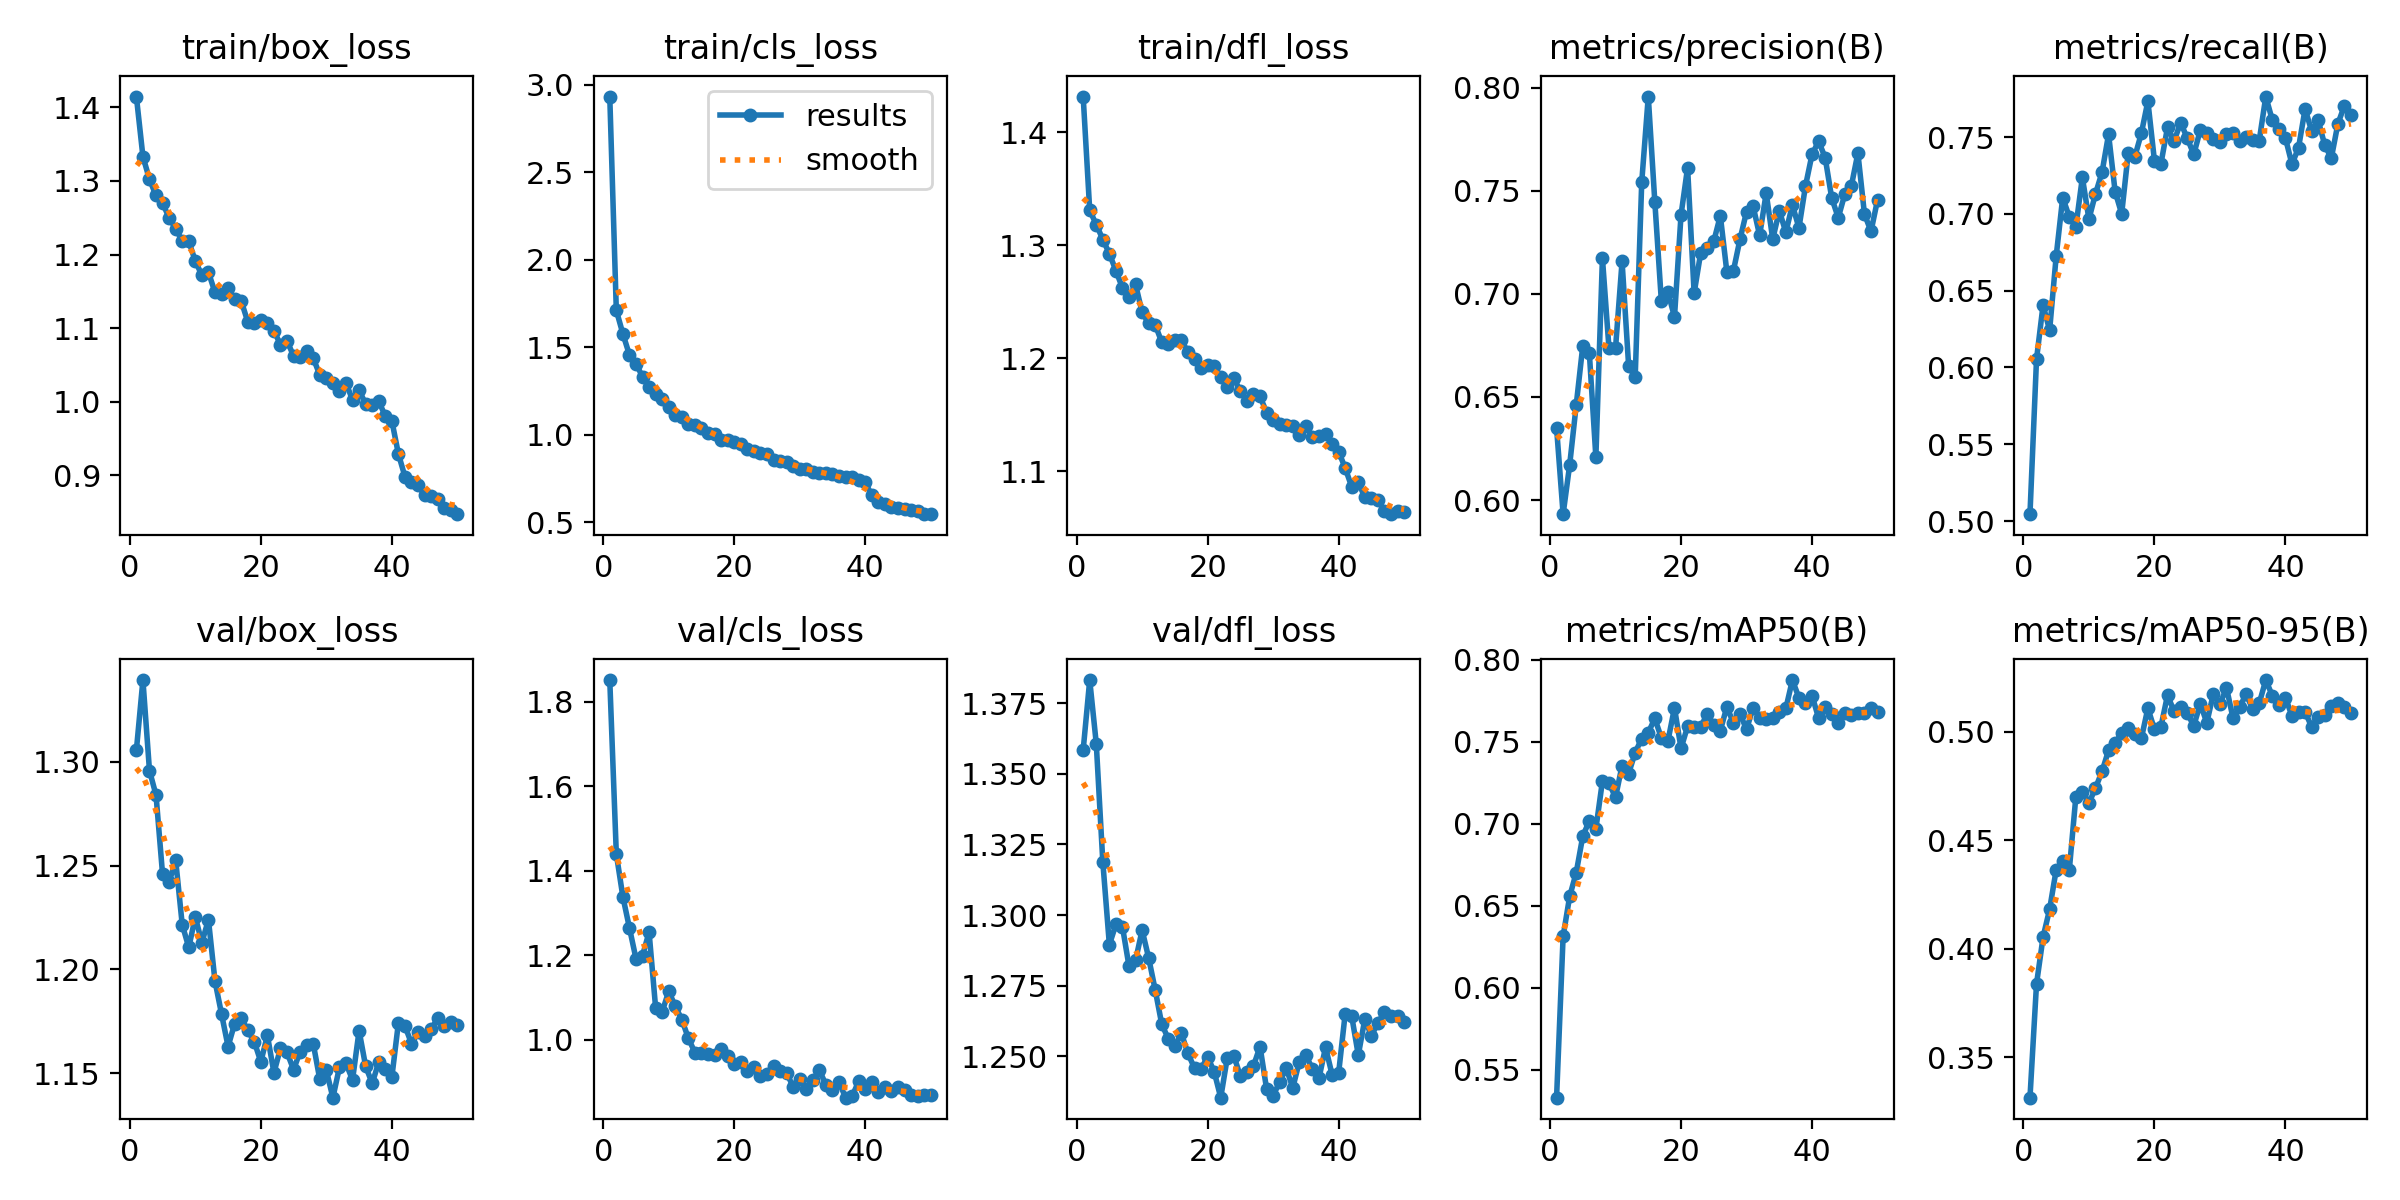

In [19]:
from IPython.display import Image, display

# Pad naar de trainingsmap
results_img = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/results.png"

# Toon de loss/mAP grafiek
display(Image(filename=results_img))


In [21]:
# Laad het getrainde model
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/best.pt")

# # Voorspellingen op testafbeeldingen
results = model.predict(
    source="/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images",  # map of enkele afbeelding
    conf=0.25,
    save=True,  # opslaan in 'runs/predict'
    save_txt=True
)



image 1/429 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images/1.jpg: 640x448 1 shirt, 1 skirt, 1 bag, 1 shoe, 363.2ms
image 2/429 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images/100247.jpg: 640x448 1 shirt, 1 skirt, 2 shoes, 162.0ms
image 3/429 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images/10042.jpg: 640x448 1 shirt, 1 shorts, 1 bag, 1 shoe, 164.0ms
image 4/429 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images/101957.jpg: 640x448 2 shirts, 1 shorts, 3 bags, 1 shoe, 164.4ms
image 5/429 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images/102400.jpg: 640x448 1 shirt, 1 shorts, 1 shoe, 196.3ms
image 6/429 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images/10280.jpg: 640x448 1 jacket, 2 shirts, 1 pants, 1 bag, 2 shoes, 171.5ms
image 7/429 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images/102944.jpg: 6

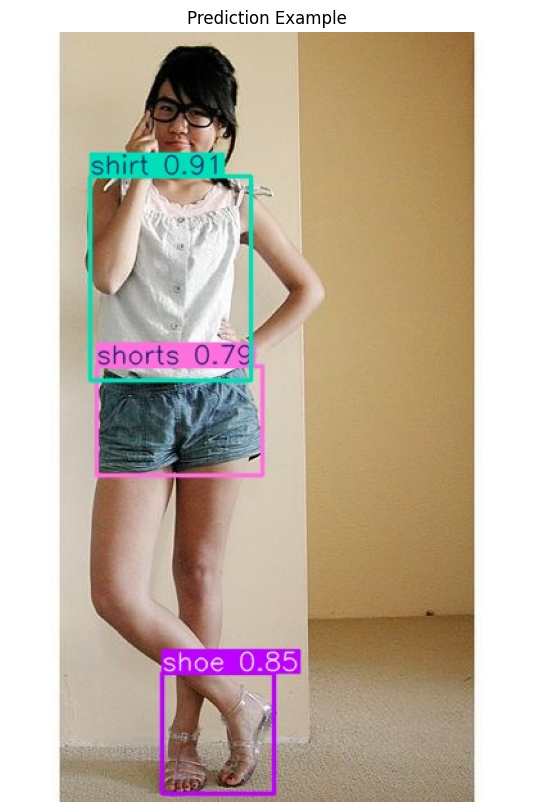

In [28]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path


# Toon een van de geplotte afbeeldingen
pred_img_path = sorted(Path("runs/detect/predict").glob("*.jpg"))[4]

img = cv2.imread(str(pred_img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Prediction Example")
plt.show()


In [42]:
import os
import glob
import pandas as pd
from PIL import Image
from ultralytics import YOLO

# 🔍 Vind automatisch het meest recente YOLOv8 experiment
runs_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs'
list_of_runs = glob.glob(f'{runs_dir}/*')
if not list_of_runs:
    raise FileNotFoundError(f"Geen experimenten gevonden in {runs_dir}")

latest_run_dir = max(list_of_runs, key=os.path.getctime)
weights_path = os.path.join(latest_run_dir, 'weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Bestand niet gevonden: {weights_path}")

# 🧠 Laad het YOLOv8-model
model = YOLO(weights_path)
model.eval()

# 📂 Testset pad
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images'
submission_output_path = '/content/submission.csv'

# 🔍 Predictiefunctie
def predict_model(image_path):
    results = model.predict(image_path, conf=0.25, verbose=False)

    img = Image.open(image_path)
    w_img, h_img = img.size

    preds = []
    for r in results:
        if r.boxes is not None and len(r.boxes) > 0:
            for box in r.boxes:
                cls = int(box.cls.item())
                conf = round(float(box.conf.item()), 4)

                xmin, ymin, xmax, ymax = box.xyxy[0].tolist()
                cx = (xmin + xmax) / 2 / w_img
                cy = (ymin + ymax) / 2 / h_img
                bw = (xmax - xmin) / w_img
                bh = (ymax - ymin) / h_img

                preds.extend([
                    cls,
                    conf,
                    round(cx, 6),
                    round(cy, 6),
                    round(bw, 6),
                    round(bh, 6)
                ])
    return preds

# 📸 Verwerk testafbeeldingen
all_test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
all_test_images.sort()

submission_data = {
    'id': [],
    'predictions': []
}

for img_name in all_test_images:
    img_path = os.path.join(test_images_dir, img_name)
    preds_list = predict_model(img_path)

    preds_string = ",".join([str(p) for p in preds_list])
    preds_string = f'[{preds_string}]'

    image_id = os.path.splitext(img_name)[0]
    submission_data['id'].append(image_id)
    submission_data['predictions'].append(preds_string)

# 💾 Maak CSV-bestand
df_submission = pd.DataFrame(submission_data)
df_submission.to_csv(submission_output_path, index=False)

print(f'Submission bestand opgeslagen in: {submission_output_path}')


Submission bestand opgeslagen in: /content/submission.csv


In [29]:
def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df


In [31]:
create_submission(results, df_test, 'test.csv', le)

NameError: name 'df_test' is not defined